In [1]:
%pip install geoparse torch_geometric cell-gears pyro-ppl mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 68.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 107.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 46.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4

In [2]:
import GEOparse
import os
import sys
sys.path.append('/kaggle/input/gears-perturbation-optimizer')
import anndata as ad
import pandas as pd
import gzip
from tqdm import tqdm
from gears.utils import dataverse_download
from gears import PertData
import scanpy as sc
from feature_selection import BayesianFeatureSelector
import plotly.express as px
from itertools import combinations
from zipfile import ZipFile
from scipy.sparse import csr_matrix, issparse
from scipy.stats import pearsonr, spearmanr
import numpy as np
import pickle

# Download AML scRNA dataset
https://pubmed.ncbi.nlm.nih.gov/30827681/

In [3]:
scRNA_aml = GEOparse.get_GEO(geo="GSE116256")
scrna_dataDir = f"scrna_data"
os.makedirs(scrna_dataDir, exist_ok=True)

08-Feb-2025 03:36:24 DEBUG utils - Directory ./ already exists. Skipping.
08-Feb-2025 03:36:24 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE116nnn/GSE116256/soft/GSE116256_family.soft.gz to ./GSE116256_family.soft.gz
100%|██████████| 8.35k/8.35k [00:00<00:00, 18.9kB/s]
08-Feb-2025 03:36:25 DEBUG downloader - Size validation passed
08-Feb-2025 03:36:25 DEBUG downloader - Moving /tmp/tmpoxh_pzei to /kaggle/working/GSE116256_family.soft.gz
08-Feb-2025 03:36:25 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE116nnn/GSE116256/soft/GSE116256_family.soft.gz
08-Feb-2025 03:36:25 INFO GEOparse - Parsing ./GSE116256_family.soft.gz: 
08-Feb-2025 03:36:25 DEBUG GEOparse - DATABASE: GeoMiame
08-Feb-2025 03:36:25 DEBUG GEOparse - SERIES: GSE116256
08-Feb-2025 03:36:25 DEBUG GEOparse - PLATFORM: GPL18573
08-Feb-2025 03:36:25 DEBUG GEOparse - PLATFORM: GPL24106
08-Feb-2025 03:36:25 DEBUG GEOparse - SAMPLE: GSM3587923
08-Feb-2025 03:36:25 DEBU

In [4]:
for i, (gsm_name, gsm) in enumerate(scRNA_aml.gsms.items()):
  gsm.download_supplementary_files(download_sra=False, email='emockler@ucsc.edu', directory=scrna_dataDir)

100%|██████████| 1.61M/1.61M [00:01<00:00, 1.65MB/s]
08-Feb-2025 03:36:27 DEBUG downloader - Size validation passed
08-Feb-2025 03:36:27 DEBUG downloader - Moving /tmp/tmpzmfqv_0b to /kaggle/working/scrna_data/Supp_GSM3587923_AML1012-D0/GSM3587923_AML1012-D0.dem.txt.gz
08-Feb-2025 03:36:27 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3587nnn/GSM3587923/suppl/GSM3587923_AML1012-D0.dem.txt.gz
100%|██████████| 57.8k/57.8k [00:00<00:00, 93.6kB/s]
08-Feb-2025 03:36:29 DEBUG downloader - Size validation passed
08-Feb-2025 03:36:29 DEBUG downloader - Moving /tmp/tmpk2779ely to /kaggle/working/scrna_data/Supp_GSM3587924_AML1012-D0-anno/GSM3587924_AML1012-D0.anno.txt.gz
08-Feb-2025 03:36:29 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3587nnn/GSM3587924/suppl/GSM3587924_AML1012-D0.anno.txt.gz
100%|██████████| 1.26M/1.26M [00:01<00:00, 1.29MB/s]
08-Feb-2025 03:36:30 DEBUG downloader - Size validation passed
08-Feb-20

# Load AML scRNA dataset

In [5]:
def load_gzipped_txt(file_path):
    with gzip.open(file_path, 'rt') as f:
        df = pd.read_csv(f, sep='\t', index_col=0)
    return df

def load_anndata(dem_path, anno_path=None, condition=None, cell_type=None):
    dem_df = load_gzipped_txt(dem_path)
    var_df = pd.DataFrame(index=dem_df.index)
    var_df['gene_name'] = var_df.index

    if anno_path and os.path.exists(anno_path):
        anno_df = load_gzipped_txt(anno_path)
        anno_df['condition'] = 'ctrl'
        anno_df = anno_df.rename(columns={'CellType': 'cell_type'})
        adata = ad.AnnData(X=dem_df.T, obs=anno_df, var=var_df)
    else:
        raise ValueError(f"Annotation file {anno_path} not found for {dem_path}")

    return adata

visited_folders = set()

aml_dict = {}
control_dict = {}
aml_cell_lines_dict = {}

data_folders = os.listdir(scrna_dataDir)

for folder in data_folders:
    if "nanopore" in folder:
        visited_folders.add(folder)
        continue
    
    folder_path = os.path.join(scrna_dataDir, folder)
    if os.path.isdir(folder_path) and folder not in visited_folders:
        sample_id = folder.split('_')[-1].replace('-anno', '')
        geo_id = folder.split('_')[1]
        base_fileName = f"{geo_id}_{sample_id}"
        
        dem_file = os.path.join(folder_path, f"{base_fileName}.dem.txt.gz")
        anno_file = os.path.join(folder_path, f"{base_fileName}.anno.txt.gz")
            
        if not os.path.exists(anno_file):
            for potential_anno_folder in data_folders:
                if potential_anno_folder.endswith(f"{sample_id}-anno"):
                    anno_folder_path = os.path.join(scrna_dataDir, potential_anno_folder)
                    anno_geo_id = potential_anno_folder.split('_')[1]
                    potential_anno_file = os.path.join(anno_folder_path, f"{anno_geo_id}_{sample_id}.anno.txt.gz")
                    if os.path.exists(potential_anno_file):
                        anno_file = potential_anno_file
                        visited_folders.add(potential_anno_folder)
                        break
        
        if not os.path.exists(dem_file):
            for potential_dem_folder in data_folders:
                if potential_dem_folder.split('_')[-1] == sample_id and not potential_dem_folder.endswith('-anno'):
                    dem_folder_path = os.path.join(scrna_dataDir, potential_dem_folder)
                    dem_geo_id = potential_dem_folder.split('_')[1]
                    potential_dem_file = os.path.join(dem_folder_path, f"{dem_geo_id}_{sample_id}.dem.txt.gz")
                    if os.path.exists(potential_dem_file):
                        dem_file = potential_dem_file
                        visited_folders.add(potential_dem_folder)
                        break

        if dem_file and anno_file:
            if sample_id.startswith('BM'):
                sample_type = 'control'
            elif sample_id in ['MUTZ3', 'OCI-AML3']:
                sample_type = 'cell_line'
            else:
                sample_type = 'aml'
                
            sample_info = {'dem_path': dem_file, 'anno_path': anno_file}
            
            if sample_type == 'aml':
                aml_dict[sample_id] = sample_info
            elif sample_type == 'control':
                control_dict[sample_id] = sample_info
            elif sample_type == 'cell_line':
                aml_cell_lines_dict[sample_id] = sample_info
            
            visited_folders.add(folder)

print(f"Identified {len(aml_dict)} AML samples, {len(control_dict)} control samples, and {len(aml_cell_lines_dict)} AML cell lines.")
print("AML Samples:", aml_dict.keys())
print("Control Samples:", control_dict.keys())
print("AML Cell Lines:", aml_cell_lines_dict.keys())

Identified 35 AML samples, 6 control samples, and 2 AML cell lines.
AML Samples: dict_keys(['AML420B-D0', 'AML707B-D41', 'AML997-D0', 'AML371-D0', 'AML210A-D0', 'AML371-D34', 'AML1012-D0', 'AML475-D0', 'AML420B-D35', 'AML722B-D49', 'AML329-D37', 'AML707B-D0', 'AML997-D35', 'AML556-D31', 'AML722B-D0', 'AML328-D29', 'AML328-D0', 'AML707B-D18', 'AML329-D20', 'AML328-D171', 'AML419A-D0', 'AML921A-D0', 'AML870-D14', 'AML328-D113', 'AML556-D15', 'AML329-D0', 'AML916-D0', 'AML314-D0', 'AML707B-D113', 'AML475-D29', 'AML556-D0', 'AML420B-D14', 'AML314-D31', 'AML870-D0', 'AML707B-D97'])
Control Samples: dict_keys(['BM1', 'BM4', 'BM5-34p38n', 'BM2', 'BM3', 'BM5-34p'])
AML Cell Lines: dict_keys(['OCI-AML3', 'MUTZ3'])


In [6]:
# Get unique AML samples
unique_aml_map = {}
unique_control_map = {}

# Group AML samples by base ID
for sample_id in aml_dict.keys():
    base_id = sample_id.split('-')[0]
    if base_id not in unique_aml_map:
        unique_aml_map[base_id] = []
    unique_aml_map[base_id].append(sample_id)

# Group control samples by base ID
for sample_id in control_dict.keys():
    base_id = sample_id.split('-')[0]
    if base_id not in unique_control_map:
        unique_control_map[base_id] = []
    unique_control_map[base_id].append(sample_id)

print(f"Unique AML samples ({len(unique_aml_map)}):")
for base_id, samples in sorted(unique_aml_map.items()):
    print(f"{base_id}: {sorted(samples)}")

print(f"\nUnique control samples ({len(unique_control_map)}):")
for base_id, samples in sorted(unique_control_map.items()):
    print(f"{base_id}: {sorted(samples)}")

Unique AML samples (16):
AML1012: ['AML1012-D0']
AML210A: ['AML210A-D0']
AML314: ['AML314-D0', 'AML314-D31']
AML328: ['AML328-D0', 'AML328-D113', 'AML328-D171', 'AML328-D29']
AML329: ['AML329-D0', 'AML329-D20', 'AML329-D37']
AML371: ['AML371-D0', 'AML371-D34']
AML419A: ['AML419A-D0']
AML420B: ['AML420B-D0', 'AML420B-D14', 'AML420B-D35']
AML475: ['AML475-D0', 'AML475-D29']
AML556: ['AML556-D0', 'AML556-D15', 'AML556-D31']
AML707B: ['AML707B-D0', 'AML707B-D113', 'AML707B-D18', 'AML707B-D41', 'AML707B-D97']
AML722B: ['AML722B-D0', 'AML722B-D49']
AML870: ['AML870-D0', 'AML870-D14']
AML916: ['AML916-D0']
AML921A: ['AML921A-D0']
AML997: ['AML997-D0', 'AML997-D35']

Unique control samples (5):
BM1: ['BM1']
BM2: ['BM2']
BM3: ['BM3']
BM4: ['BM4']
BM5: ['BM5-34p', 'BM5-34p38n']


In [7]:
# Create dictionaries for unique samples, taking the first alphabetically
unique_aml_samples = {base_id: min(samples) for base_id, samples in unique_aml_map.items()}
unique_control_samples = {base_id: min(samples) for base_id, samples in unique_control_map.items()}

print(f"Selected AML samples ({len(unique_aml_samples)}):")
for base_id, sample in sorted(unique_aml_samples.items()):
    print(f"{base_id}: {sample}")

print(f"\nSelected control samples ({len(unique_control_samples)}):")
for base_id, sample in sorted(unique_control_samples.items()):
    print(f"{base_id}: {sample}")

Selected AML samples (16):
AML1012: AML1012-D0
AML210A: AML210A-D0
AML314: AML314-D0
AML328: AML328-D0
AML329: AML329-D0
AML371: AML371-D0
AML419A: AML419A-D0
AML420B: AML420B-D0
AML475: AML475-D0
AML556: AML556-D0
AML707B: AML707B-D0
AML722B: AML722B-D0
AML870: AML870-D0
AML916: AML916-D0
AML921A: AML921A-D0
AML997: AML997-D0

Selected control samples (5):
BM1: BM1
BM2: BM2
BM3: BM3
BM4: BM4
BM5: BM5-34p


In [8]:
unique_aml_ids = list(unique_aml_samples.values())
unique_control_ids = list(unique_control_samples.values())
filtered_aml_dict = {key: aml_dict[key] for key in unique_aml_ids}
filtered_control_dict = {key: control_dict[key] for key in unique_control_ids}


# Load gene set used to train GEARS

In [9]:
if not os.path.exists(f"scrna_data/norman_umi_go"):
  if not os.path.exists(f"scrna_data/norman_umi_go.tar.gz"):
    # Dataloaders used for training
    dataverse_download('https://dataverse.harvard.edu/api/access/datafile/6979957', 'norman_umi_go.tar.gz')
  ## Extract and set up dataloader directory
  import tarfile
  with tarfile.open('norman_umi_go.tar.gz', 'r:gz') as tar:
      tar.extractall()
      tar.close()
  del tar

# load AnnData with genes list
adata_path = os.path.join('norman_umi_go', 'perturb_processed.h5ad')
trained_adata = sc.read_h5ad(adata_path)
trained_genes = trained_adata.var.gene_name.to_list()
del trained_adata

Downloading...
100%|██████████| 1.10G/1.10G [00:51<00:00, 21.1MiB/s]


In [10]:
print(f"{len(trained_genes)} total pretrained genes")

5054 total pretrained genes


# Normalize expression data

In [11]:
def normalize_data(adata):
    # GEARS needs constant dimensionality for gene expression vector 
    # 0-counts will be flagged in GEARS PertData preprocessing 
    # 1. Filter genes by minimum counts
    # sc.pp.filter_genes(adata, min_counts=2)

    # 2. Normalize total counts per cell
    sc.pp.normalize_total(adata)

    # 3. Log transform the data
    sc.pp.log1p(adata)


def build_anndata(sampleID, paths):
    adata = load_anndata(paths['dem_path'], paths['anno_path'])
    
    # Ensure every gene in trained_genes is in adata
    trained_genes_set = set(trained_genes)
    adata_genes_set = set(adata.var_names)

    missing_genes = list(trained_genes_set - adata_genes_set)

    if missing_genes:
        # Create a zero matrix for missing genes
        zeros = pd.DataFrame(0, index=adata.obs_names, columns=missing_genes)
        # Create an AnnData object for the missing genes
        missing_genes_adata = ad.AnnData(X=zeros.values, 
                                         obs=adata.obs.copy(), 
                                         var=pd.DataFrame(index=missing_genes))
        missing_genes_adata.var['gene_name'] = missing_genes

        # Concatenate with original adata
        complete_adata = ad.concat([adata, missing_genes_adata], axis=1)
        complete_adata.obs = adata.obs.copy()
        del adata
    # Reorder genes to match trained_genes order
    complete_adata = complete_adata[:, trained_genes]
    
    # Normalize and preprocess data
    normalize_data(complete_adata)

    # Add sample_id to obs
    complete_adata.obs['sample_id'] = sampleID

    return complete_adata

In [12]:
def batch_correct(sample_dict, aml_keys):
    combined_adata_list = []
    sample_to_batch = {}
    batch_to_sample = {}

    # Load and preprocess all samples
    for batch_id, (sample_id, paths) in enumerate(tqdm(sample_dict.items())):
        adata = build_anndata(sample_id, paths)
        adata.obs['sample_type'] = 'case' if sample_id in aml_keys else 'healthy'
        
        # Filter cells based on PredictionRefined and sample type
        if 'PredictionRefined' in adata.obs.columns:
            mask = ((adata.obs['sample_type'] == 'case') & (adata.obs['PredictionRefined'] == 'malignant')) | \
                  ((adata.obs['sample_type'] == 'healthy') & (adata.obs['PredictionRefined'] == 'normal'))
            adata = adata[mask]
        
        combined_adata_list.append(adata)
        sample_to_batch[sample_id] = batch_id
        batch_to_sample[str(batch_id)] = sample_id

    # Combine all samples
    combined_adata = combined_adata_list[0].concatenate(
        *combined_adata_list[1:], batch_key='batch')
    
    print("Done!")
    return combined_adata, batch_to_sample

In [13]:
aml_keys = list((filtered_aml_dict).keys())
control_keys = list(filtered_control_dict.keys())

combined_adata, batch_to_sample = batch_correct(filtered_aml_dict | filtered_control_dict, aml_keys)

100%|██████████| 21/21 [00:38<00:00,  1.81s/it]


Done!


In [14]:
combined_adata

AnnData object with n_obs × n_vars = 17749 × 5054
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'cell_type', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'condition', 'sample_id', 'sample_type', 'NanoporeTranscripts', 'batch'
    var: 'gene_name'

In [15]:
# Create masks for malignant and healthy cells
malignant_mask = combined_adata.obs['PredictionRefined'] == 'malignant'
healthy_mask = combined_adata.obs['PredictionRefined'] == 'normal'

# Depending on whether the expression matrix is sparse or dense,
# convert to a dense array for computing mean expression
if issparse(combined_adata.X):
    malignant_expr = combined_adata[malignant_mask, :].X.toarray()
    healthy_expr = combined_adata[healthy_mask, :].X.toarray()
else:
    malignant_expr = combined_adata[malignant_mask, :].X
    healthy_expr = combined_adata[healthy_mask, :].X

# Compute the mean expression for each gene across malignant and healthy cells:
malignant_means = malignant_expr.mean(axis=0)
healthy_means = healthy_expr.mean(axis=0)

# Identify genes with increased expression in malignant cells (average malignant > average healthy)
upregulated_bool = malignant_means > healthy_means
upregulated_genes = combined_adata.var_names[upregulated_bool]

print(f"Number of genes upregulated in malignant cells: {len(upregulated_genes)}")

# Create a new AnnData object that retains only the upregulated genes:
combined_adata_upregulated = combined_adata[:, upregulated_genes].copy()

Number of genes upregulated in malignant cells: 2035


In [16]:
combined_adata_upregulated

AnnData object with n_obs × n_vars = 17749 × 2035
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'cell_type', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'condition', 'sample_id', 'sample_type', 'NanoporeTranscripts', 'batch'
    var: 'gene_name'

# Feature selection

In [17]:
expr_df = pd.DataFrame(combined_adata_upregulated.X, columns=combined_adata_upregulated.var_names, index=combined_adata_upregulated.obs_names)
y_series = pd.Series(combined_adata_upregulated.obs['sample_type'], index=combined_adata_upregulated.obs_names).replace({'case': 1, 'healthy': 0})

In [18]:
import importlib
import feature_selection

# Reload the module to apply local changes
importlib.reload(feature_selection)

<module 'feature_selection' from '/kaggle/input/gears-perturbation-optimizer/feature_selection.py'>

Using CUDA (GPU) acceleration.


Training:  82%|████████████████████████████████       | 823/1000 [07:51<01:41,  1.75iter/s, train_loss=5.8126, val_loss=5.8381, acc=0.9121, f1=0.9371]


Early stopping triggered.


BayesianFeatureSelector(base_cumulative_density_threshold=0.05,
                        base_sensitivity=0.05,
                        checkpoint_path='checkpoint_0.params',
                        max_features=1000, unique_id=0, verbose=True)

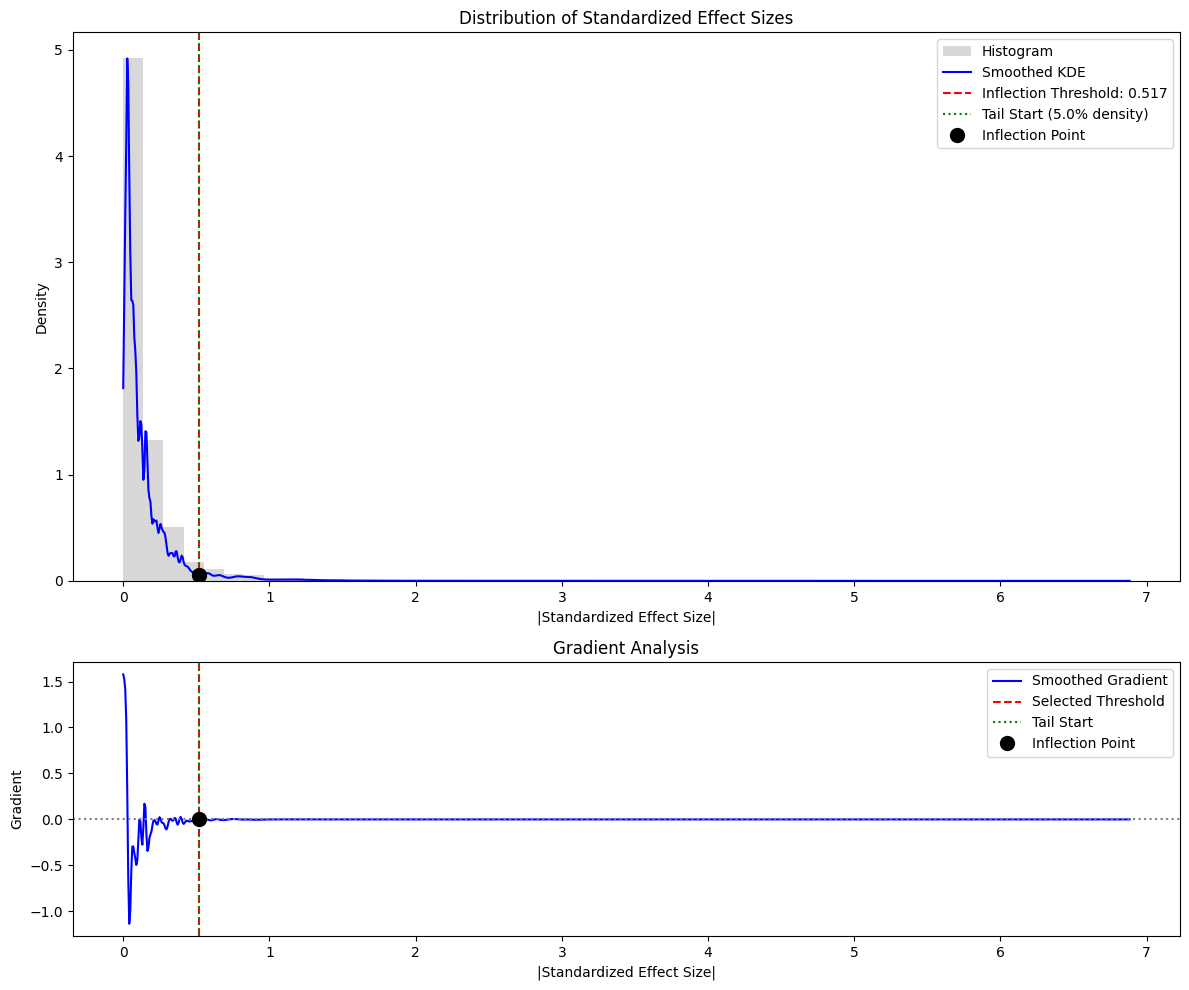

In [19]:
selector = feature_selection.BayesianFeatureSelector(unique_id=0, verbose=True, lr=0.0001, max_features=1000, base_sensitivity=0.05, base_cumulative_density_threshold=0.05)
selector.fit(expr_df, y_series)

In [20]:
selector.selected_features_

Index(['RSRP1', 'SH3BGRL3', 'CAPZA1', 'S100A9', 'S100A8', 'TPM3', 'LMNA',
       'TAGLN2', 'RGS18', 'KDM5B', 'C1orf186', 'IRF2BP2', 'SMYD3', 'RPS7',
       'MRPL33', 'PLEK', 'VAMP8', 'LRRFIP1', 'MAPKAPK3', 'CXCL8', 'CD74',
       'PPP1R18', 'LST1', 'AIF1', 'CLIC1', 'HLA-DRA', 'HLA-DRB1', 'MARCKS',
       'CITED2', 'RNASET2', 'ACTB', 'CD36', 'CAV1', 'IL3RA', 'CD99', 'TMSB4X',
       'CXorf21', 'TIMP1', 'XIST', 'CTSB', 'RUNX1T1', 'ANXA1', 'GSN', 'FCN1',
       'EGFL7', 'TPP1', 'C1QTNF4', 'NEAT1', 'MALAT1', 'ALDH3B1', 'CTSC',
       'PAFAH1B2', 'JAML', 'UBASH3B', 'APLP2', 'SRGN', 'HHEX', 'PDLIM1',
       'GAPDH', 'MGST1', 'METTL7A', 'PFDN5', 'PRR13', 'GTSF1', 'MYL6',
       'COX6A1', 'TPT1', 'ITM2B', 'LGALS3', 'SRSF5', 'ATP8B4', 'IQGAP1',
       'ALDOA', 'CORO1A', 'PYCARD', 'ITGAX', 'CYBA', 'CD68', 'EVI2A', 'GRN',
       'HOXB-AS3', 'HOXB4', 'ACTG1', 'MYL12A', 'CST3', 'PRSS57', 'CFD',
       'UQCR11', 'IER2', 'RPL18A', 'HCST', 'TYROBP', 'PLD3', 'RPS9', 'COMT',
       'PRAME', 'LGALS1', 'E

In [21]:
selector.feature_stats

,feature_name,beta_mean,beta_std,effect_size,is_selected
1735,CFD,2.007482,0.291627,6.883741,True
1857,TYROBP,1.102417,0.327924,3.361806,True
552,CD74,0.682933,0.290413,2.351595,True
793,XIST,0.907430,0.445600,2.036423,True
1218,GTSF1,0.757211,0.444201,1.704658,True
...,...,...,...,...,...
1993,RPS19BP1,0.000147,0.315066,0.000466,False
695,MPLKIP,0.000126,0.298686,0.000421,False
1144,ADIRF,0.000124,0.321249,0.000386,False
1919,AKT1S1,-0.000037,0.324355,0.000114,False


In [22]:
selector.validation_results_

,label,sum_correct,count,accuracy,accuracy_std,draw_count,avg_prediction,prediction_std
AML921A-D0_CTGAGGGAACTG-12,1.0,824,824,1.000000,0.000000,824,1.000000,0.000000
AML419A-D0_TGAGCAGGAAGG-11,1.0,824,824,1.000000,0.000000,824,1.000000,0.000000
AML556-D0_AGACCCGGAGAA-9,1.0,824,824,1.000000,0.000000,824,1.000000,0.000000
AML556-D0_ATCGTGCCGTTG-9,1.0,824,824,1.000000,0.000000,824,1.000000,0.000000
BM3_ATGTGTGGCTGA-20,0.0,775,824,0.940534,0.008239,824,0.059466,0.236495
...,...,...,...,...,...,...,...,...
AML921A-D0_GCCCGTGCCGTC-12,1.0,824,824,1.000000,0.000000,824,1.000000,0.000000
BM4_GTGTAGATCGGC-17,0.0,765,824,0.928398,0.008982,824,0.071602,0.257828
AML921A-D0_TACCTCACGGCC-12,1.0,824,824,1.000000,0.000000,824,1.000000,0.000000
AML870-D0_ACTATTCGGTGC-13,1.0,824,824,1.000000,0.000000,824,1.000000,0.000000


In [23]:
px.histogram(selector.validation_results_, x='accuracy', color='label', log_y=True)

# Generate perturbation conditions

In [24]:
def generate_perturbations(genes_iterable, generate_double_perts=True):
    # Prepare a list of all perturbation conditions
    single_perts = [[gene] for gene in genes_iterable]
    if generate_double_perts:
        double_perts = [(gene1, gene2) for gene1, gene2 in combinations(genes_iterable, 2)]
    else:
        double_perts = []
    all_perts = (single_perts + double_perts)  # Replicate each perturbation three times

    return all_perts

perturbations_to_predict = generate_perturbations(selector.selected_features_, generate_double_perts=False)

In [25]:
len(perturbations_to_predict)

100

# Initialize pretrained GEARS model & dataloader

In [26]:
gears_data_dir = f"GEARS_data"
os.makedirs(gears_data_dir, exist_ok=True)

In [27]:
# Download pretrained GEARS model (Norman et al. 2019 dataset)
dataverse_download('https://dataverse.harvard.edu/api/access/datafile/10457098', f'{gears_data_dir}/model.zip')

# Extract and set up model directory
with ZipFile(f'{gears_data_dir}/model.zip', 'r') as zip:
    zip.extractall(path = f'{gears_data_dir}/model')
del zip

# Load pretrained model config
pretrainedConfig = pickle.loads(open(f'{gears_data_dir}/model/model_ckpt/config.pkl', 'rb').read())
pretrainedConfig

Downloading...
100%|██████████| 8.50M/8.50M [00:00<00:00, 12.1MiB/s]


{'hidden_size': 64,
 'num_go_gnn_layers': 1,
 'num_gene_gnn_layers': 1,
 'decoder_hidden_size': 16,
 'num_similar_genes_go_graph': 20,
 'num_similar_genes_co_express_graph': 20,
 'coexpress_threshold': 0.4,
 'uncertainty': False,
 'uncertainty_reg': 1,
 'direction_lambda': 0.1,
 'G_go': tensor([[   0,    0,    0,  ..., 9649, 9669, 9693],
         [   0,  126,  514,  ..., 9649, 9669, 9693]]),
 'G_go_weight': tensor([1.0000, 0.1739, 0.1600,  ..., 1.0000, 1.0000, 1.0000]),
 'G_coexpress': tensor([[   0,    1,    2,  ..., 5050, 5052, 5053],
         [   0,    1,    2,  ..., 5050, 5052, 5053]]),
 'G_coexpress_weight': tensor([1.0000, 0.9998, 0.9998,  ..., 1.0000, 1.0000, 1.0000]),
 'device': 'cuda:6',
 'num_genes': 5054,
 'num_perts': 9853,
 'no_perturb': False}

In [28]:
# GEARS does not define the nonzero gene idx for unperturbed test data, so we need to do it manually

def adata_define_nonzero_gene_idx(adata):
    import scipy.sparse as sp
    # Use scipy.sparse.find to get non-zero entries (rows, cols, values)
    _, non_zero_cols, _ = sp.find(adata.X)
    # Get unique columns with non-zero entries
    unique_non_zero_cols = np.unique(non_zero_cols)
    # Map these indices to gene names
    non_zeros_gene_idx = {adata.var_names[idx]: idx for idx in unique_non_zero_cols}
    # Store the result
    adata.uns['non_zeros_gene_idx'] = non_zeros_gene_idx

In [29]:
aml_data = PertData(f'{gears_data_dir}/aml_scrna_embeddings')
combined_adata.X = csr_matrix(combined_adata.X)
adata_define_nonzero_gene_idx(combined_adata)
aml_data.new_data_process(dataset_name='aml_scrna_embeddings', adata=combined_adata, skip_calc_de=True)
aml_data.prepare_split(split='no_split')

aml_data.dataloader = aml_data.get_dataloader(batch_size=1)
# Convert condition boolean mask to numpy array
combined_adata.obs['condition'] = combined_adata.obs['condition'].astype('str')

Downloading...
100%|██████████| 9.46M/9.46M [00:00<00:00, 11.0MiB/s]
Downloading...
100%|██████████| 559k/559k [00:00<00:00, 1.62MiB/s]
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:01<00:00,  1.94s/it]
Done!
Saving new dataset pyg object at GEARS_data/aml_scrna_embeddings/aml_scrna_embeddings/data_pyg/cell_graphs.pkl
Done!
Creating new splits....
Saving new splits at GEARS_data/aml_scrna_embeddings/aml_scrna_embeddings/splits/aml_scrna_embeddings_no_split_1_0.75.pkl
Done!
Creating dataloaders....
Dataloaders created...


In [30]:
def GEARS_patched_init_(self, pert_data, 
                 device = 'cuda',
                 weight_bias_track = False, 
                 proj_name = 'GEARS', 
                 exp_name = 'GEARS'):
        """
        Initialize GEARS model

        Parameters
        ----------
        pert_data: PertData object
            dataloader for perturbation data
        device: str
            Device to run the model on. Default: 'cuda'
        weight_bias_track: bool
            Whether to track performance on wandb. Default: False
        proj_name: str
            Project name for wandb. Default: 'GEARS'
        exp_name: str
            Experiment name for wandb. Default: 'GEARS'

        Returns
        -------
        None

        """
        import torch
        self.weight_bias_track = weight_bias_track
        
        if self.weight_bias_track:
            import wandb
            wandb.init(project=proj_name, name=exp_name)  
            self.wandb = wandb
        else:
            self.wandb = None
        
        self.device = device
        self.config = None
        
        self.dataloader = pert_data.dataloader
        self.adata = pert_data.adata
        self.node_map = pert_data.node_map
        self.node_map_pert = pert_data.node_map_pert
        self.data_path = pert_data.data_path
        self.dataset_name = pert_data.dataset_name
        self.split = pert_data.split
        self.seed = pert_data.seed
        self.train_gene_set_size = pert_data.train_gene_set_size
        self.set2conditions = pert_data.set2conditions
        self.subgroup = pert_data.subgroup
        self.gene_list = pert_data.gene_names.values.tolist()
        self.pert_list = pert_data.pert_names.tolist()
        self.num_genes = len(self.gene_list)
        self.num_perts = len(self.pert_list)
        self.default_pert_graph = pert_data.default_pert_graph
        self.saved_pred = {}
        self.saved_logvar_sum = {}
        
        ctrl_mask = (self.adata.obs.condition == 'ctrl').to_numpy()
        self._ctrl_expression = torch.tensor(  # Assign to a regular attribute
                np.mean(self.adata.X[ctrl_mask], axis=0)
            ).reshape(-1,).to(self.device)
        pert_full_id2pert = dict(self.adata.obs[['condition_name', 'condition']].values)
        self.dict_filter = {pert_full_id2pert[i]: j for i, j in
                            self.adata.uns['non_zeros_gene_idx'].items() if
                            i in pert_full_id2pert}
        self.ctrl_adata = self.adata[self.adata.obs['condition'] == 'ctrl']
        
        gene_dict = {g:i for i,g in enumerate(self.gene_list)}
        self.pert2gene = {p: gene_dict[pert] for p, pert in
                          enumerate(self.pert_list) if pert in self.gene_list}

In [ ]:
from gears import GEARS
import torch

def check_available_perturbations(gears_wrapper, perturbations_to_predict):
    """
    Check which genes from perturbations_to_predict are available in GEARS pert list.
    
    Args:
        gears_wrapper: GEARS model instance
        perturbations_to_predict: List of perturbations to check
    
    Returns:
        tuple: (available_perts, unavailable_perts)
    """
    available_perts = []
    unavailable_perts = []
    
    # Flatten the perturbations list and get unique genes
    all_genes = set()
    for pert in perturbations_to_predict:
        if isinstance(pert, (list, tuple)):
            all_genes.update(pert)
        else:
            all_genes.add(pert)
    
    # Check each gene
    for gene in all_genes:
        if gene in gears_wrapper.pert_list:
            available_perts.append(gene)
        else:
            unavailable_perts.append(gene)
    
    print(f"\nGene Availability Check:")
    print(f"Available genes: {len(available_perts)}/{len(all_genes)}")
    print("\nAvailable genes:")
    print(available_perts)
    print("\nUnavailable genes:")
    print(unavailable_perts)
    
    return available_perts, unavailable_perts


def run_inference(aml_data, perturbations_to_predict):
    """
    Run GEARS inference using existing batch size configuration.
    
    Args:
        aml_data: Prepared PertData object with existing batch_size
        perturbations_to_predict: List of perturbations to predict
    """
    from scipy.stats import pearsonr, spearmanr
    from types import MethodType
    
    n_cells = len(aml_data.adata)
    batch_size = aml_data.dataloader['test_loader'].batch_size
    print(f"Running predictions for {n_cells} cells using batch_size={batch_size}")

    # Define the ctrl_expression property to return the attribute
    def ctrl_expression_property(self):
        return self._ctrl_expression

    GEARS.ctrl_expression = property(ctrl_expression_property)

    # Monkey patch the __init__ method
    GEARS.__init__ = GEARS_patched_init_

    # Load model for inference
    gears_wrapper = GEARS(
        aml_data,
        device='cpu',# 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu',
        weight_bias_track=False
    )
    gears_wrapper.load_pretrained(f'{gears_data_dir}/model/model_ckpt')
    gears_wrapper.model.eval()

     # Check available perturbations before running predictions
    available_perts, unavailable_perts = check_available_perturbations(gears_wrapper, perturbations_to_predict)
    
    # Filter perturbations to only include available ones
    filtered_perturbations = [pert for pert in perturbations_to_predict 
                            if all(gene in available_perts for gene in (pert if isinstance(pert, (list, tuple)) else [pert]))]
    
    if not filtered_perturbations:
        raise ValueError("No valid perturbations available for prediction!")
    
    print(f"\nProceeding with {len(filtered_perturbations)} valid perturbations")
    
    # Get cell IDs and original expression
    cell_ids = aml_data.adata.obs_names
    original_expression = aml_data.adata.X.toarray() if issparse(aml_data.adata.X) else aml_data.adata.X
    
    predictions = {}
    with torch.no_grad():
        # Process baseline (no perturbation) in batches
        baseline_preds = []
        for i in tqdm(range(0, n_cells, batch_size), desc="Baseline predictions"):
            batch_end = min(i + batch_size, n_cells)
            batch_size_actual = batch_end - i
            batch_preds = gears_wrapper.predict([[] for _ in range(batch_size_actual)])
            baseline_preds.append(batch_preds[''])  # no perturbation is empty string
        
        predictions['no_perturbation'] = baseline_preds
        
        # Calculate baseline metrics for each cell
        baseline_metrics = pd.DataFrame(index=cell_ids)
        baseline_metrics['mse'] = np.mean((original_expression - baseline_preds) ** 2, axis=1)
        baseline_metrics['pearson'] = [
            pearsonr(original_expression[i], baseline_preds[i])[0] 
            for i in range(n_cells)
        ]
        baseline_metrics['spearman'] = [
            spearmanr(original_expression[i], baseline_preds[i])[0]
            for i in range(n_cells)
        ]
        
        # Get predictions for all perturbations
        # Accumulate predictions across all cells
        # We'll use a dictionary where each key is a perturbation (the key returned by .predict) and 
        # its value is the list of prediction arrays from each batch.
    #     all_batch_preds = {}
        
    #     for i in tqdm(range(0, n_cells, batch_size), desc="Predicting perturbations"):
    #         # Call .predict on the list of filtered perturbations for the current batch
    #         batch_preds = gears_wrapper.predict(filtered_perturbations)
    #         for key, preds in batch_preds.items():
    #             # If this key is being encountered for the first time, initialize the list.
    #             if key not in all_batch_preds:
    #                 all_batch_preds[key] = [preds]
    #             else:
    #                 all_batch_preds[key].append(preds)
    
    # # Concatenate predictions for each perturbation (each key) across batch axis (axis=0)
    # predictions = { key: val for key, val in (all_batch_preds | predictions).items() }
    
    # # Create predictions df with cell IDs from the observation table in aml_data.adata
    # cell_ids = aml_data.adata.obs_names
    # predictions_df = pd.DataFrame(predictions, index=cell_ids)
    predictions_df = None
    
    print("\nBaseline Prediction Performance:")
    print(f"Mean MSE: {baseline_metrics['mse'].mean():.4f} (±{baseline_metrics['mse'].std():.4f})")
    print(f"Mean Pearson: {baseline_metrics['pearson'].mean():.4f} (±{baseline_metrics['pearson'].std():.4f})")
    print(f"Mean Spearman: {baseline_metrics['spearman'].mean():.4f} (±{baseline_metrics['spearman'].std():.4f})")
    
    # Add percentile rankings
    for metric in ['mse', 'pearson', 'spearman']:
        baseline_metrics[f'{metric}_percentile'] = baseline_metrics[metric].rank(pct=True)
    
    
    return predictions_df, baseline_metrics, filtered_perturbations, gears_wrapper

predictions_df, baseline_metrics, filtered_perturbations, gears_wrapper = run_inference(aml_data, perturbations_to_predict)

# Find cells with best/worst predictions
best_predicted = baseline_metrics.nsmallest(5, 'mse')
worst_predicted = baseline_metrics.nlargest(5, 'mse')

# Get perturbation effects relative to baseline
def get_perturbation_effect(predictions_df, pert):
    return predictions_df[pert] - predictions_df['no_perturbation']

# Example: Calculate effect size for a perturbation
# pert_effect = get_perturbation_effect(predictions_df, str(filtered_perturbations[0][0]))

# Analyze cells with different baseline prediction quality
good_cells = baseline_metrics[baseline_metrics['mse_percentile'] < 0.1].index
poor_cells = baseline_metrics[baseline_metrics['mse_percentile'] > 0.9].index

# good_cell_predictions = predictions_df.loc[good_cells]
# poor_cell_predictions = predictions_df.loc[poor_cells]

Running predictions for 17749 cells using batch_size=1

Gene Availability Check:
Available genes: 72/100

Available genes:
['ANXA1', 'IRF2BP2', 'VAMP8', 'TPP1', 'TAGLN2', 'CTSC', 'GSN', 'CD68', 'CYBA', 'LMNA', 'PRAME', 'RPS7', 'COMT', 'PFDN5', 'PRSS57', 'LST1', 'TPT1', 'CST3', 'HOXB4', 'LRRFIP1', 'TMSB4X', 'EGFL7', 'GRN', 'SRGN', 'SH3BGRL3', 'MRPL33', 'C1QTNF4', 'GAPDH', 'CORO1A', 'ACTB', 'ETS2', 'METTL7A', 'CFD', 'ITM2B', 'PPP1R18', 'RPS9', 'RPL18A', 'CD99', 'PLD3', 'CITED2', 'MYL6', 'COX6A1', 'IER2', 'TIMP1', 'CAPZA1', 'PDLIM1', 'HHEX', 'ACTG1', 'SRSF5', 'PAFAH1B2', 'RUNX1T1', 'UBASH3B', 'IQGAP1', 'LGALS1', 'CTSB', 'APLP2', 'MAPKAPK3', 'PRR13', 'SMYD3', 'MYL12A', 'AIF1', 'PTTG1IP', 'PYCARD', 'KDM5B', 'UQCR11', 'RNASET2', 'TPM3', 'GTSF1', 'CLIC1', 'ALDOA', 'TYROBP', 'MGST1']

Unavailable genes:
['RSRP1', 'CXorf21', 'JAML', 'MARCKS', 'MALAT1', 'C1orf186', 'ALDH3B1', 'CD74', 'CD36', 'RGS18', 'IL3RA', 'HLA-DRB1', 'FCN1', 'S100A8', 'S100A9', 'ITGB2', 'CAV1', 'XIST', 'HCST', 'HOXB-AS3', 'I

Baseline predictions:  52%|█████▏    | 9229/17749 [06:52<05:55, 23.98it/s] 

In [ ]:
# # Get the metrics for good cells
# good_cells_metrics = baseline_metrics.loc[good_cells]

# # Find the worst performing cell among good cells (highest MSE)
# worst_of_good = good_cells_metrics.nlargest(1, 'mse')

# print("Metrics for worst-performing cell among good cells:")
# print(f"Cell ID: {worst_of_good.index[0]}")
# print(f"MSE: {worst_of_good['mse'].iloc[0]:.6f}")
# print(f"Pearson correlation: {worst_of_good['pearson'].iloc[0]:.6f}")
# print(f"Spearman correlation: {worst_of_good['spearman'].iloc[0]:.6f}")
# print(f"MSE percentile (overall): {worst_of_good['mse_percentile'].iloc[0]:.6f}")

In [ ]:
# best_of_good = good_cells_metrics.nsmallest(1, 'mse')

# print("Metrics for best-performing cell among good cells:")
# print(f"Cell ID: {best_of_good.index[0]}")
# print(f"MSE: {best_of_good['mse'].iloc[0]:.6f}")
# print(f"Pearson correlation: {best_of_good['pearson'].iloc[0]:.6f}")
# print(f"Spearman correlation: {best_of_good['spearman'].iloc[0]:.6f}")
# print(f"MSE percentile (overall): {best_of_good['mse_percentile'].iloc[0]:.6f}")

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Get the cell ID of interest
# cell_ids = best_of_good.index

# # Get actual and predicted values for this cell
# actual_values = aml_data.adata[cell_ids].X.toarray() if issparse(aml_data.adata.X) else aml_data.adata[cell_ids].X
# # predicted_values = predictions_df.loc[cell_id, 'no_perturbation']

# # Create a DataFrame for easier plotting
# comparison_df = pd.DataFrame({
#     'Actual': np.mean(actual_values, axis=0),
#     # 'Predicted': predicted_values,
#     'Gene': aml_data.adata.var_names
# })

# # Alternative approach to categorize expression levels
# expression_quantiles = comparison_df['Actual'].quantile([0.25, 0.5, 0.75])
# comparison_df['Expression_Level'] = 'Very Low'
# comparison_df.loc[comparison_df['Actual'] > expression_quantiles[0.25], 'Expression_Level'] = 'Low'
# comparison_df.loc[comparison_df['Actual'] > expression_quantiles[0.5], 'Expression_Level'] = 'Medium'
# comparison_df.loc[comparison_df['Actual'] > expression_quantiles[0.75], 'Expression_Level'] = 'High'

# # # Create a figure with multiple subplots
# # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# # # 1. Scatter plot with expression levels colored
# # sns.scatterplot(data=comparison_df, 
# #                 x='Actual', 
# #                 y='Predicted', 
# #                 hue='Expression_Level',
# #                 alpha=0.6,
# #                 ax=ax1)
# # ax1.plot([min(actual_values), max(actual_values)], 
# #          [min(actual_values), max(actual_values)], 
# #          'r--', label='Perfect Prediction')
# # ax1.set_title(f'Actual vs Predicted Values\nPearson: {best_of_good["pearson"].iloc[0]:.3f}, Spearman: {best_of_good["spearman"].iloc[0]:.3f}')
# # ax1.set_xlabel('Actual Expression')
# # ax1.set_ylabel('Predicted Expression')

# # # 2. Rank scatter plot
# # actual_ranks = comparison_df['Actual'].rank()
# # predicted_ranks = comparison_df['Predicted'].rank()
# # sns.scatterplot(x=actual_ranks, 
# #                 y=predicted_ranks, 
# #                 hue=comparison_df['Expression_Level'],
# #                 alpha=0.6,
# #                 ax=ax2)
# # ax2.plot([min(actual_ranks), max(actual_ranks)], 
# #          [min(actual_ranks), max(actual_ranks)], 
# #          'r--', label='Perfect Rank Agreement')
# # ax2.set_title('Rank Comparison\n(Shows Spearman Correlation)')
# # ax2.set_xlabel('Actual Expression Rank')
# # ax2.set_ylabel('Predicted Expression Rank')

# # plt.tight_layout()

# # # 3. Additional analysis of outliers and expression levels
# # print("\nAnalysis of Prediction Quality by Expression Level:")
# # for level in ['Very Low', 'Low', 'Medium', 'High']:
# #     level_df = comparison_df[comparison_df['Expression_Level'] == level]
# #     if len(level_df) > 1:  # Need at least 2 points for correlation
# #         pearson = pearsonr(level_df['Actual'], level_df['Predicted'])[0]
# #         spearman = spearmanr(level_df['Actual'], level_df['Predicted'])[0]
# #         mean_expr = level_df['Actual'].mean()
# #         print(f"\n{level} Expression Genes:")
# #         print(f"Number of genes: {len(level_df)}")
# #         print(f"Mean expression: {mean_expr:.3f}")
# #         print(f"Pearson correlation: {pearson:.3f}")
# #         print(f"Spearman correlation: {spearman:.3f}")

# # # 4. Find the top 10 most discrepant predictions
# # comparison_df['Absolute_Error'] = abs(comparison_df['Actual'] - comparison_df['Predicted'])
# # print("\nTop 10 Most Discrepant Predictions:")
# # print(comparison_df.nlargest(10, 'Absolute_Error')[['Gene', 'Actual', 'Predicted', 'Absolute_Error', 'Expression_Level']])

# # # 5. Additional statistics about zero expression genes
# # zero_expr_count = (comparison_df['Actual'] == 0).sum()
# # zero_pred_count = (comparison_df['Predicted'] == 0).sum()
# # print(f"\nZero Expression Statistics:")
# # print(f"Number of genes with zero actual expression: {zero_expr_count}")
# # print(f"Number of genes with zero predicted expression: {zero_pred_count}")

In [ ]:
# comparison_df

# Perturbation

In [ ]:
def reinit_gears(self):
        """Reinitialize the GEARS model"""
        # Define the ctrl_expression property to return the attribute
        def ctrl_expression_property(self):
            return self._ctrl_expression

        GEARS.ctrl_expression = property(ctrl_expression_property)

        def GEARS_patched_init_(self, pert_data, 
                 device = 'cuda',
                 weight_bias_track = False, 
                 proj_name = 'GEARS', 
                 exp_name = 'GEARS'):
            """
            Initialize GEARS model

            Parameters
            ----------
            pert_data: PertData object
                dataloader for perturbation data
            device: str
                Device to run the model on. Default: 'cuda'
            weight_bias_track: bool
                Whether to track performance on wandb. Default: False
            proj_name: str
                Project name for wandb. Default: 'GEARS'
            exp_name: str
                Experiment name for wandb. Default: 'GEARS'

            Returns
            -------
            None

            """
            import torch
            self.weight_bias_track = weight_bias_track
            
            if self.weight_bias_track:
                import wandb
                wandb.init(project=proj_name, name=exp_name)  
                self.wandb = wandb
            else:
                self.wandb = None
            
            self.device = device
            self.config = None
            
            self.dataloader = pert_data.dataloader
            self.adata = pert_data.adata
            self.node_map = pert_data.node_map
            self.node_map_pert = pert_data.node_map_pert
            self.data_path = pert_data.data_path
            self.dataset_name = pert_data.dataset_name
            self.split = pert_data.split
            self.seed = pert_data.seed
            self.train_gene_set_size = pert_data.train_gene_set_size
            self.set2conditions = pert_data.set2conditions
            self.subgroup = pert_data.subgroup
            self.gene_list = pert_data.gene_names.values.tolist()
            self.pert_list = pert_data.pert_names.tolist()
            self.num_genes = len(self.gene_list)
            self.num_perts = len(self.pert_list)
            self.default_pert_graph = pert_data.default_pert_graph
            self.saved_pred = {}
            self.saved_logvar_sum = {}
            
            ctrl_mask = (self.adata.obs.condition == 'ctrl').to_numpy()
            self._ctrl_expression = torch.tensor(  # Assign to a regular attribute
                    np.mean(self.adata.X[ctrl_mask], axis=0)
                ).reshape(-1,).to(self.device)
            pert_full_id2pert = dict(self.adata.obs[['condition_name', 'condition']].values)
            self.dict_filter = {pert_full_id2pert[i]: j for i, j in
                                self.adata.uns['non_zeros_gene_idx'].items() if
                                i in pert_full_id2pert}
            self.ctrl_adata = self.adata[self.adata.obs['condition'] == 'ctrl']
            
            gene_dict = {g:i for i,g in enumerate(self.gene_list)}
            self.pert2gene = {p: gene_dict[pert] for p, pert in
                            enumerate(self.pert_list) if pert in self.gene_list}

        # Monkey patch the __init__ method
        GEARS.__init__ = GEARS_patched_init_

        # Load model for inference
        gears_wrapper = GEARS(
            self.original_pert_data,
            device='cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu',
            weight_bias_track=False
        )
        gears_wrapper.load_pretrained(self.gears_data_dir)
        gears_wrapper.model.eval()

        torch.cuda.empty_cache()
        if torch.backends.mps.is_available():
            torch.mps.empty_cache()

        return gears_wrapper

In [ ]:
import torch
import perturbation_evaluator

import importlib
# Reload the module to apply local changes
importlib.reload(perturbation_evaluator)

# Get the list of upregulated genes from the filtered AnnData.
upregulated_genes = combined_adata_upregulated.var_names

# Create a mapping from gene name to index based on aml_data.adata.
gene_to_index = {gene: i for i, gene in enumerate(aml_data.adata.var_names)}

# Now, for each upregulated gene, get its index from aml_data.adata.
gene_subset = [gene_to_index[gene] for gene in upregulated_genes if gene in gene_to_index]

print(f"Found indices for {len(gene_subset)} genes out of {len(upregulated_genes)} upregulated genes.")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Extract cell states for all these good cells.
sorted_adata = aml_data.adata[good_cells].copy()

# Convert sorted_adata to a dense array so that cells can be sorted by their overall expression.
if issparse(sorted_adata.X):
    X_array = sorted_adata.X.toarray()
else:
    X_array = sorted_adata.X

# Sort the cells by total expression (row sum)
X_tensor = torch.tensor(X_array)
_, sort_idx = torch.sort(X_tensor.sum(dim=1), descending=False)

# Reorder the cells by sorted indices
sorted_adata = sorted_adata[sort_idx.numpy()]

# Separate the good cells into normal and malignant subsets based on 'PredictionRefined'
healthy_adata = sorted_adata[sorted_adata.obs['PredictionRefined'] == 'normal']
cancer_adata = sorted_adata[sorted_adata.obs['PredictionRefined'] == 'malignant']

In [ ]:
import pickle
import pandas as pd
from datetime import datetime

def save_evaluation_results(evaluation_results, filename_prefix="evaluation_results", save_pickle=False):
    """
    Save evaluation results to CSV (and optionally as a pickle file).

    Parameters
    ----------
    evaluation_results : list
        A list of evaluation result objects. Each result should have at least the following:
            - result.perturbation : an object (converted to a string for saving)
            - result.scores : a dict with keys:
                   'baseline_classifier', 'classifier', 'wasserstein', 'stability', 'density', 'total'
    filename_prefix : str, optional
        Prefix for the output filenames (default: "evaluation_results").
    save_pickle : bool, optional
        Whether to also save the raw evaluation results as a pickle file (default: False).

    Returns
    -------
    tuple:
        csv_filename (str): Filename of the saved CSV file.
        pickle_filename (str or None): Filename of the saved pickle file if save_pickle is True; otherwise, None.
    """
    # Create a timestamp that will be appended to the filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Prepare a list of dictionaries from the results
    results_list = []
    for result in evaluation_results:
        result_dict = {
            'perturbation': str(result.perturbation),
            'baseline_classifier': result.scores.get('baseline_classifier', None),
            'classifier_score': result.scores.get('classifier', None),
            'wasserstein': result.scores.get('wasserstein', None),
            'stability': result.scores.get('stability', None),
            'density': result.scores.get('density', None),
            'total_score': result.scores.get('total', None)
        }
        results_list.append(result_dict)

    # Convert the list to a DataFrame
    results_df = pd.DataFrame(results_list)

    # Save the DataFrame to a CSV file
    csv_filename = f"{filename_prefix}_{timestamp}.csv"
    results_df.to_csv(csv_filename, index=False)

    # Optionally, also save the raw evaluation results as a pickle file
    pickle_filename = None
    if save_pickle:
        pickle_filename = f"{filename_prefix}_{timestamp}.pkl"
        with open(pickle_filename, "wb") as f:
            pickle.dump(evaluation_results, f)

    # Report the saved filenames
    print("Results saved to:")
    if save_pickle:
        print(f"1. {pickle_filename}")
        print(f"2. {csv_filename}")
    else:
        print(csv_filename)

    return csv_filename, pickle_filename

In [ ]:
def extract_perturbations_by_classifier_change(evaluation_results, scenario="healthy_to_aml"):
    """
    Extract perturbations from evaluation results based on the change in classifier score relative to baseline.
    
    This version expects evaluation_results to be a pandas DataFrame (for example, loaded from the CSV file).
    
    Parameters
    ----------
    evaluation_results : pd.DataFrame
        A DataFrame of evaluation results with at least the following columns:
            - 'perturbation'
            - 'baseline_classifier'
            - 'classifier'
    scenario : str, optional
        The scenario to use for selecting perturbations. Options are:
          - "healthy_to_aml": Select perturbations that increase the classifier score over the baseline
                              (i.e. push healthy cells into an AML-like state).
          - "aml_to_healthy": Select perturbations that decrease the classifier score below the baseline
                              (i.e. push AML cells toward a healthy state).
    
    Returns
    -------
    selected_perturbations : list
        A list of perturbation identifiers (as they were saved in the CSV) that satisfy the condition.
    """
    import pandas as pd

    if scenario not in ["healthy_to_aml", "aml_to_healthy"]:
        raise ValueError("Scenario must be one of 'healthy_to_aml' or 'aml_to_healthy'.")

    selected_perturbations = []
    for idx, row in evaluation_results.iterrows():
        baseline = row.get('baseline_classifier')
        new_score = row.get('classifier')
        # Skip if we cannot find either score (or if they're NaN)
        if pd.isna(baseline) or pd.isna(new_score):
            continue

        if scenario == "healthy_to_aml" and new_score > 0.5:
            selected_perturbations.append(row['perturbation'])
        elif scenario == "aml_to_healthy" and new_score < 0.5:
            selected_perturbations.append(row['perturbation'])

    return selected_perturbations[:100]

## healthy -> AML

In [ ]:
aml_LoF_genes = ['TP53', 'RUNX1', 'CEBPA', 'TET2', 'SPI1', 'GATA2', 'IKZF1', 'IRF8', 'DNMT3A', 'PHLPP1', 'PHLPP2', 'FLT3', 'NPM1', 'IDH1', 'IDH2', 'ASXL1', 'CBL']
cancer_driving_perturbations = generate_perturbations(
    list(set(gears_wrapper.pert_list) & set(aml_LoF_genes))
)
len(cancer_driving_perturbations)
print(f"Number of cancer driving perturbations: {len(cancer_driving_perturbations)}")
cancer_driving_perturbations

In [ ]:
all_perturbations = generate_perturbations(list(set(gears_wrapper.pert_list) & set(healthy_adata.var.index.tolist())), generate_double_perts=False)

In [ ]:
def evaluate_perturbations(perturbation_list, scenario="aml_to_healthy", results_filename="healthyToAML"):
    """
    Evaluate perturbations using the generator-based evaluator and immediately write results to CSV.
    
    Parameters:
        perturbation_list (list): List of candidate perturbations.
        scenario (str, optional): Scenario to use.
                                  For example, "aml_to_healthy" means perturb healthy cells toward an AML-like state.
        results_filename (str, optional): Prefix for the CSV file to be written.
    
    Returns:
        csv_filename (str): The name of the CSV file that was written.
    """
    import csv
    from datetime import datetime

    # Determine which AnnData to use as the current (baseline) state.
    current_adata = healthy_adata if scenario == 'aml_to_healthy' else cancer_adata

    evaluator = perturbation_evaluator.PerturbationEvaluator(
        classifier=selector,
        reference_state=cancer_adata if scenario == 'aml_to_healthy' else healthy_adata,
        device=device,
        invert_classifier_score=False,
        gears_data_dir=f"{gears_data_dir}/model",
        gene_subset=gene_subset,
        template_adata=combined_adata
    )
    
    # Use the generator-based evaluation method to process perturbations in chunks.
    results_gen = evaluator.evaluate_perturbations_generator(current_adata, perturbation_list, chunk_size=100)
    
    # Create a CSV filename with an appended timestamp.
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f"{results_filename}_{timestamp}.csv"
    
    # Open the CSV file for writing and write a header.
    with open(csv_filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        header = ["perturbation", "baseline_classifier", "classifier", "wasserstein", "stability", "density", "total"]
        writer.writerow(header)
        
        # Iterate over each result from the generator and write it to the CSV.
        for result in results_gen:
            scores = result.scores
            row = [
                result.perturbation,
                scores.get("baseline_classifier", None),
                scores.get("classifier", None),
                scores.get("wasserstein", None),
                scores.get("stability", None),
                scores.get("density", None),
                scores.get("total", None)
            ]
            writer.writerow(row)
    
    print(f"Results saved to {csv_filename}")
    return csv_filename

Found local copy...
Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 20.23it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations:  95%|█████████▌| 2915/3055 [12:40<14:14,  6.10s/it]

In [ ]:
evaluation_result_path = evaluate_perturbations(all_perturbations, 
                                                results_filename="healthyToAML_allCases_allPerts")

# Load the CSV file containing the evaluation results.
results_df = pd.read_csv(evaluation_result_path)

if not results_df.empty:
    print("Perturbation Evaluation Results:")
    for idx, row in results_df.iterrows():
        print(f"\nPerturbation #{idx+1}:")
        print(f"  Perturbation: {row['perturbation']}")
        print(f"  Baseline Classifier Score: {float(row['baseline_classifier']):.4f}")
        print(f"  Predicted Classifier Score: {float(row['classifier']):.4f}")
        print(f"  Wasserstein Distance: {float(row['wasserstein']):.4f}")
        print(f"  Stability: {float(row['stability']):.4f}")
        print(f"  Density: {float(row['density']):.4f}")
        print(f"  Total Score: {float(row['total']):.4f}")
else:
    print("No valid perturbations found.")

In [ ]:
selected_perturbations = extract_perturbations_by_classifier_change(results_df)
evaluation_results = evaluate_perturbations(generate_perturbations([pert[0] for pert in selected_perturbations], generate_double_perts=True), 
                                            results_filename="healthyToAML_allCases_selectedPerts")
# Print results for each evaluation result in the list.
if evaluation_results:
    print("Perturbation Evaluation Results:")
    for idx, result in enumerate(evaluation_results, start=1):
        print(f"\nPerturbation #{idx}:")
        print(f"  Perturbation: {result.perturbation}")
        print(f"  Baseline Classifier Score: {result.scores['baseline_classifier']:.4f}")
        print(f"  Predicted Classifier Score: {result.scores['classifier']:.4f}")
        print(f"  Wasserstein Distance: {result.scores['wasserstein']:.4f}")
        print(f"  Stability: {result.scores['stability']:.4f}")
        print(f"  Density: {result.scores['density']:.4f}")
        print(f"  Total Score: {result.scores['total']:.4f}")
else:
    print("No valid perturbations found.")

del evaluation_results

### per-individual perturbations

In [60]:
# First, prepare patient-specific datasets and train patient-specific classifiers
patient_specific_classifiers = {}
patient_specific_cancer_adata = {}

# Split cancer data by patient
for i, pid in enumerate(cancer_adata.obs['patient_id'].unique()):
    # Get this patient's AML cells
    patient_adata = cancer_adata[cancer_adata.obs['patient_id'] == pid].copy()
    patient_specific_cancer_adata[pid] = patient_adata
    
    # Create expression dataframe for this patient's cells and all control cells
    patient_expr_df = pd.DataFrame(
        np.vstack([
            patient_adata.X.toarray() if issparse(patient_adata.X) else patient_adata.X,
            healthy_adata.X.toarray() if issparse(healthy_adata.X) else healthy_adata.X
        ]),
        columns=patient_adata.var_names
    )
    
    # Create labels (1 for patient's AML cells, 0 for control cells)
    patient_labels = pd.Series(
        [1] * patient_adata.n_obs + [0] * healthy_adata.n_obs,
        index=range(len(patient_expr_df))
    )
    
    # Train a patient-specific classifier
    print(f"\nTraining classifier for patient {pid}...")
    patient_selector = BayesianFeatureSelector(
        unique_id=hash(pid) % 10000,  # Create a unique ID based on patient ID
        verbose=True,
        lr=0.0001,
        max_features=1000,
        base_sensitivity=0.05,
        base_cumulative_density_threshold=0.05
    )
    patient_selector.fit(patient_expr_df, patient_labels)
    patient_specific_classifiers[pid] = patient_selector

# Now create patient-specific evaluators using the patient-specific classifiers
evaluators_by_patient = {}
for pid, patient_adata in patient_specific_cancer_adata.items():
    evaluator = perturbation_evaluator.PerturbationEvaluator(
        classifier=patient_specific_classifiers[pid],  # Use patient-specific classifier
        reference_state=patient_adata,
        device=device,
        invert_classifier_score=True,
        gears_data_dir=f"{gears_data_dir}/model",
        template_adata=patient_adata
    )
    evaluators_by_patient[pid] = evaluator

print("\nCreated per-patient evaluators with patient-specific classifiers.")

Created 12 patient-specific AML AnnData objects.


NameError: name 'PerturbationEvaluator' is not defined

In [86]:
# Perform perturbation evaluation for each patient using the generator-based evaluation.
# Here, we apply the perturbations to healthy_adata (as our baseline state), letting each evaluator
# compute scores based on how the healthy cells, after perturbation, compare to that patient's AML reference.
evaluation_results_by_patient = {}

for pid, evaluator in evaluators_by_patient.items():
    print(f"\nEvaluating perturbations for patient {pid} ...")
    
    # Evaluate all candidate perturbations, streaming results directly to CSV.
    csv_all = evaluate_perturbations(
        perturbation_list=all_perturbations,
        scenario="aml_to_healthy",
        results_filename=f"{pid}_allPerts"
    )
    
    # Store the CSV filename (or, if desired, load the CSV into a DataFrame).
    evaluation_results_by_patient[pid] = csv_all
    print(f"All-perturbation results for patient {pid} saved to {csv_all}")
    
    # Load the CSV to extract selected perturbations.
    df_all = pd.read_csv(csv_all)
    # Depending on your extract_perturbations_by_classifier_change function,
    # you might need it to work on a DataFrame (one option is to convert the DataFrame rows into a list).
    selected_perturbations = extract_perturbations_by_classifier_change(df_all)
    
    # Generate the list of (double) perturbations for selected ones.
    # (Assuming generate_perturbations accepts a list of perturbations as input.)
    selected_perts = generate_perturbations(
        [pert[0] for pert in selected_perturbations],
        generate_double_perts=True
    )
    
    # Evaluate the selected perturbations using the generator-based method.
    csv_selected = evaluate_perturbations(
        perturbation_list=selected_perts,
        scenario="aml_to_healthy",
        results_filename=f"{pid}_selectedPerts"
    )
    print(f"Selected perturbation results for patient {pid} saved to {csv_selected}")

Found local copy...



Evaluating perturbations for patient AML420B-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 18.80it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [02:25<00:00,  1.38s/it]
Found local copy...



Evaluating perturbations for patient AML1012-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 21.88it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [02:25<00:00,  1.39s/it]
Found local copy...



Evaluating perturbations for patient AML916-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [02:53<00:00,  1.65s/it]
Found local copy...



Evaluating perturbations for patient AML921A-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 21.69it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [02:58<00:00,  1.70s/it]
Found local copy...



Evaluating perturbations for patient AML328-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 21.60it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [02:44<00:00,  1.57s/it]
Found local copy...



Evaluating perturbations for patient AML870-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 23.00it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [03:22<00:00,  1.93s/it]
Found local copy...



Evaluating perturbations for patient AML329-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 20.07it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [02:52<00:00,  1.64s/it]
Found local copy...



Evaluating perturbations for patient AML210A-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 21.56it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [02:49<00:00,  1.62s/it]
Found local copy...



Evaluating perturbations for patient AML475-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 18.90it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [03:07<00:00,  1.79s/it]
Found local copy...



Evaluating perturbations for patient AML556-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 21.81it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [02:44<00:00,  1.56s/it]
Found local copy...



Evaluating perturbations for patient AML707B-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations: 100%|██████████| 105/105 [02:45<00:00,  1.57s/it]
Found local copy...



Evaluating perturbations for patient AML419A-D0 ...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████| 1/1 [00:00<00:00, 22.38it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


Evaluating perturbations:  90%|████████▉ | 94/105 [02:20<00:16,  1.49s/it]


KeyboardInterrupt: 

In [ ]:
# Summarize the best perturbation (highest composite total score) per patient.
import pandas as pd

summary_records = []
for pid, results in evaluation_results_by_patient.items():
    if results:  # if any valid perturbation evaluation is returned
        best_result = results[0]  # results are sorted in descending order of total score
        summary_records.append({
            'patient_id': pid,
            'best_perturbation': best_result.perturbation,
            'total_score': best_result.scores['total'],
            'classifier_score': best_result.scores['classifier'],
            'wasserstein': best_result.scores['wasserstein'],
            'stability': best_result.scores['stability'],
            'density': best_result.scores['density']
        })

summary_df = pd.DataFrame(summary_records)

print("\nBest perturbations per patient:")
print(summary_df)

## AML -> healthy

In [53]:
len(generate_perturbations(filtered_perturbations))

2850

In [59]:
# Instantiate the evaluator.
# Here, since we perturb healthy cells into an AML state (i.e., higher classifier scores are desirable),
# we set invert_classifier_score=False.
evaluator = perturbation_evaluator.PerturbationEvaluator(
    classifier=selector,
    reference_state=healthy_adata,  # optional: your healthy reference states
    device=device,
    invert_classifier_score=True,
    gears_data_dir=f"{gears_data_dir}/model",
    gene_subset=gene_subset,
    template_adata=patient_adata
)
# Evaluate all the candidate perturbations in a single batched call.
evaluation_results = evaluator.evaluate_perturbations(cancer_adata, generate_perturbations(filtered_perturbations))

# Sort the evaluation results by the total score (highest score first)
evaluation_results.sort(key=lambda x: x.scores['total'], reverse=True)

if evaluation_results:
    best_result = evaluation_results[0]
    print("\nBest Single-Step Perturbation:")
    print(f"Perturbation: {best_result.perturbation}")
    print(f"Baseline Classifier Score: {best_result.scores['baseline_classifier']:.4f}")
    print(f"Classifier Score: {best_result.scores['classifier']:.4f}")
    print(f"Wasserstein Distance: {best_result.scores['wasserstein']:.4f}")
    print(f"Stability: {best_result.scores['stability']:.4f}")
    print(f"Density: {best_result.scores['density']:.4f}")
    print(f"Total Score: {best_result.scores['total']:.4f}")
else:
    print("No valid perturbations found.")

NameError: name 'patient_adata' is not defined

In [ ]:
del gears_wrapper
gears_wrapper = reinit_gears(aml_data)

In [81]:
good_cells

Index(['AML707B-D0_AACATTACGTTA-0', 'AML707B-D0_AACCGCCAAAGA-0',
       'AML707B-D0_AAGGCCGGTGCA-0', 'AML707B-D0_ACCCGGAGATCC-0',
       'AML707B-D0_ACCGCGGACTCT-0', 'AML707B-D0_ACTGTTTCCCAT-0',
       'AML707B-D0_ACTTAGACACGC-0', 'AML707B-D0_ACTTTCAGCCAN-0',
       'AML707B-D0_AGACGCGGTTCG-0', 'AML707B-D0_AGCGCCCGCACT-0',
       ...
       'BM5-34p_GGCCCCTAGCAG-19', 'BM5-34p_GGCGAGGCGAGT-19',
       'BM5-34p_GGGATGACAATA-19', 'BM5-34p_TATGGGAACCGC-19',
       'BM5-34p_TCACTTGATTAC-19', 'BM5-34p_TGATGGCAGACC-19',
       'BM5-34p_TTCACCAGGACG-19', 'BM5-34p_TTTCATTATAGC-19',
       'BM5-34p_CACATTTTAGAA-19', 'BM5-34p_GACCCCCCGTGA-19'],
      dtype='object', name='Cell', length=1774)

In [82]:
def count_patients_and_cells(good_cells):
    """
    Given a pandas Index of cell IDs (with the first substring before '_' representing the patient ID),
    returns the number of unique patients and a Pandas Series with the number of cells per patient.
    
    Parameters:
        good_cells (pd.Index): Cell IDs
    
    Returns:
        num_patients (int): Number of unique patients
        cells_per_patient (pd.Series): Count of cells per patient
    """
    # Extract the patient ID from each cell id
    patient_ids = [cell.split('_')[0] for cell in good_cells]
    
    # Count cells per patient using value_counts
    cells_per_patient = pd.Series(patient_ids).value_counts()
    
    # Number of unique patients
    num_patients = cells_per_patient.shape[0]
    
    return num_patients, cells_per_patient

num_patients, cells_per_patient = count_patients_and_cells(good_cells)
print(f"Number of unique patients: {num_patients}\n")
print("Cells per patient:")
print(cells_per_patient)

Number of unique patients: 16

Cells per patient:
AML921A-D0    526
BM5-34p       226
AML1012-D0    224
AML707B-D0    119
BM3           107
AML328-D0     103
AML556-D0     101
AML916-D0      97
BM4            86
AML329-D0      51
AML420B-D0     49
AML210A-D0     35
AML870-D0      25
AML419A-D0     17
AML475-D0       7
BM1             1
Name: count, dtype: int64
